# Runge phenomenon

This notebook demonstrates the Runge instability occuring when using high-order polynomials on a uniform grid.

We orthonormalise a set of polynomials using the Gram-Schmidt algorithm in arbitrary precision arithmetic and use it to expand and interpolate the Runge function.

In [2]:
import numpy as np
import scipy
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
from numpy.testing import assert_allclose as isclose
import matplotlib.pyplot as plt 
import numpy as np 
import scipy
from mpmath import *

# Set precision and a small number for floating-point comparisons
mp.dps = 64
eps = 1e-64

class GramSchmidt:
    """
    A class for performing the Gram-Schmidt process to obtain an orthonormal basis for a vector space.
    The basis is formed in the space of polynomials up to degree m-1.
    """

    def __init__(self, x, m):
        """
        Initializes the GramSchmidt object.

        Args:
            x (list): The input list of sample points.
            m (int): The number of basis vectors to generate.
        """
        self.x = x 
        self.m = m 
        self.A = mp.zeros(m, len(x))

        # Linear map for polynomial scalar product
        for i in range(m): 
            for j in range(len(x)):
                self.A[i, j] = x[j] ** i

        # Set basis vector as columns of matrix V
        self.V = mp.eye(m)

        # Orthonormalise V and write orthonormal basis vectors as columns of matrix U
        self.U = self.modifiedGramSchmidt(self.V) 

    def evaluateBasis(self, x, basis_element): 
        """
        Evaluates a given basis element at the points specified by x.

        Args:
            x (list): The input list of sample points.
            basis_element (int): The index of the basis element to evaluate.

        Returns:
            The evaluated basis element at each point in x.
        """
        A = mp.zeros(self.m, len(x))
        for i in range(self.m): 
            for j in range(len(x)):
                A[i, j] = x[j] ** i
        ei = self.U[:, basis_element].T * A 

        return ei
    
    def sp(self, u, v):
        """
        Computes the scalar product of two vectors.

        Args:
            u (mp.matrix): First vector.
            v (mp.matrix): Second vector.

        Returns:
            The scalar product of u and v.
        """
        return mp.fsum((u.T * self.A) * (v.T * self.A).T)

    def proj(self, u, v):
        """
        Projects vector v onto vector u.

        Args:
            u (mp.matrix): The vector to project onto.
            v (mp.matrix): The vector being projected.

        Returns:
            The projection of v onto u.
        """
        a1 = self.sp(v, u) 
        a2 = self.sp(u, u)
        return a1 / a2 * u 

    def norm(self, u):
        """
        Computes the norm of a vector.

        Args:
            u (mp.matrix): The vector whose norm is computed.

        Returns:
            The norm of vector u.
        """
        return mp.sqrt(self.sp(u, u))

    def modifiedGramSchmidt(self, V): 
        """
        Applies the Modified Gram-Schmidt process to matrix V.

        Args:
            V (mp.matrix): The matrix of vectors to orthonormalize.

        Returns:
            A matrix with orthonormalized columns.
        """
        n, k = V.rows, V.cols
        U = V.copy()
        U[:, 0] = V[:, 0] / self.norm(V[:, 0]) 

        for i in range(1, k): 
            for j in range(i, k): 
                U[:, j] = U[:, j] - self.proj(U[:, i - 1], U[:, j])

            U[:, i] = U[:, i] / self.norm(U[:, i])
        return U

    def projectFunction(self, f): 
        """
        Projects a function onto the orthonormal basis.

        Args:
            f (mp.matrix): The function to project.

        Returns:
            The coefficients of the function in the basis.
        """
        coeffs = mp.matrix(1, self.m) 

        for i in range(self.m): 
            basis = (self.U[:, i].T * self.A)
            coeffs[0, i] = mp.fsum(f * basis.T)

        return coeffs
    
    def reconstructFunction(self, coeffs, x=None): 
        """
        Reconstructs a function from its coefficients in the basis.

        Args:
            coeffs (mp.matrix): The coefficients of the function in the basis.
            x (list, optional): The points at which to evaluate the reconstructed function.

        Returns:
            The reconstructed function evaluated at each point in x.
        """
        if x is None:
            A = self.A
        else: 
            A = mp.zeros(self.m, len(x))
            for i in range(self.m): 
                for j in range(len(x)): 
                    A[i, j] = x[j] ** i
            
        frec = mp.matrix(1, A.cols)
        for i in range(self.m): 
            frec += coeffs[0, i] * (self.U[:, i].T * A)
        return frec 
    
    def debugInformation(self):
        """
        Plots unorthogonalised and orthonormalised polynomials and prints the scalar products.
        Used for debugging purposes.
        """
        m = self.m 
        u_ij = mp.zeros(m) 

        plt.title(f"Unorthogonalised polynomials m = {m}")
        for i in range(m):
            plt.plot(self.x, self.V[:, i].T * self.A, label=f"x^{i}")
        plt.legend()
        plt.show()

        plt.title(f"Orthonormalised polynomials m = {m}")
        for i in range(m):
            plt.plot(self.x, self.U[:, i].T * self.A, label=f"{i}")
        plt.legend()
        plt.show()

        print("The orthonormalised polynomials and their scalar products:")
        for i in range(m):
            for j in range(m):
                u_ij[i, j] = self.sp(self.U[:, i], self.U[:, j])
            print(f"i = {i} u_ij = {u_ij[i, :]}")


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# Set precision for mpmath
mp.dps = 32

# Define the Runge function
def runge_function(x):
    return 1 / (1 + 25 * x**2)

# Number of points and order of the polynomial
num_points       = 1000
polynomial_order = 10

# Equidistant points in the interval [-1, 1]
x_points = np.linspace(-1, 1, num_points)
y_points = [runge_function(x) for x in x_points]

# Initialize the GramSchmidt object with the x_points and the polynomial order
gram_schmidt = GramSchmidt(x_points, polynomial_order)


# Project the Runge function onto the orthonormal basis
f_values = mp.matrix(y_points).T
coeffs = gram_schmidt.projectFunction(f_values)

# Reconstruct the function from the coefficients
reconstructed_function = gram_schmidt.reconstructFunction(coeffs, x_points)


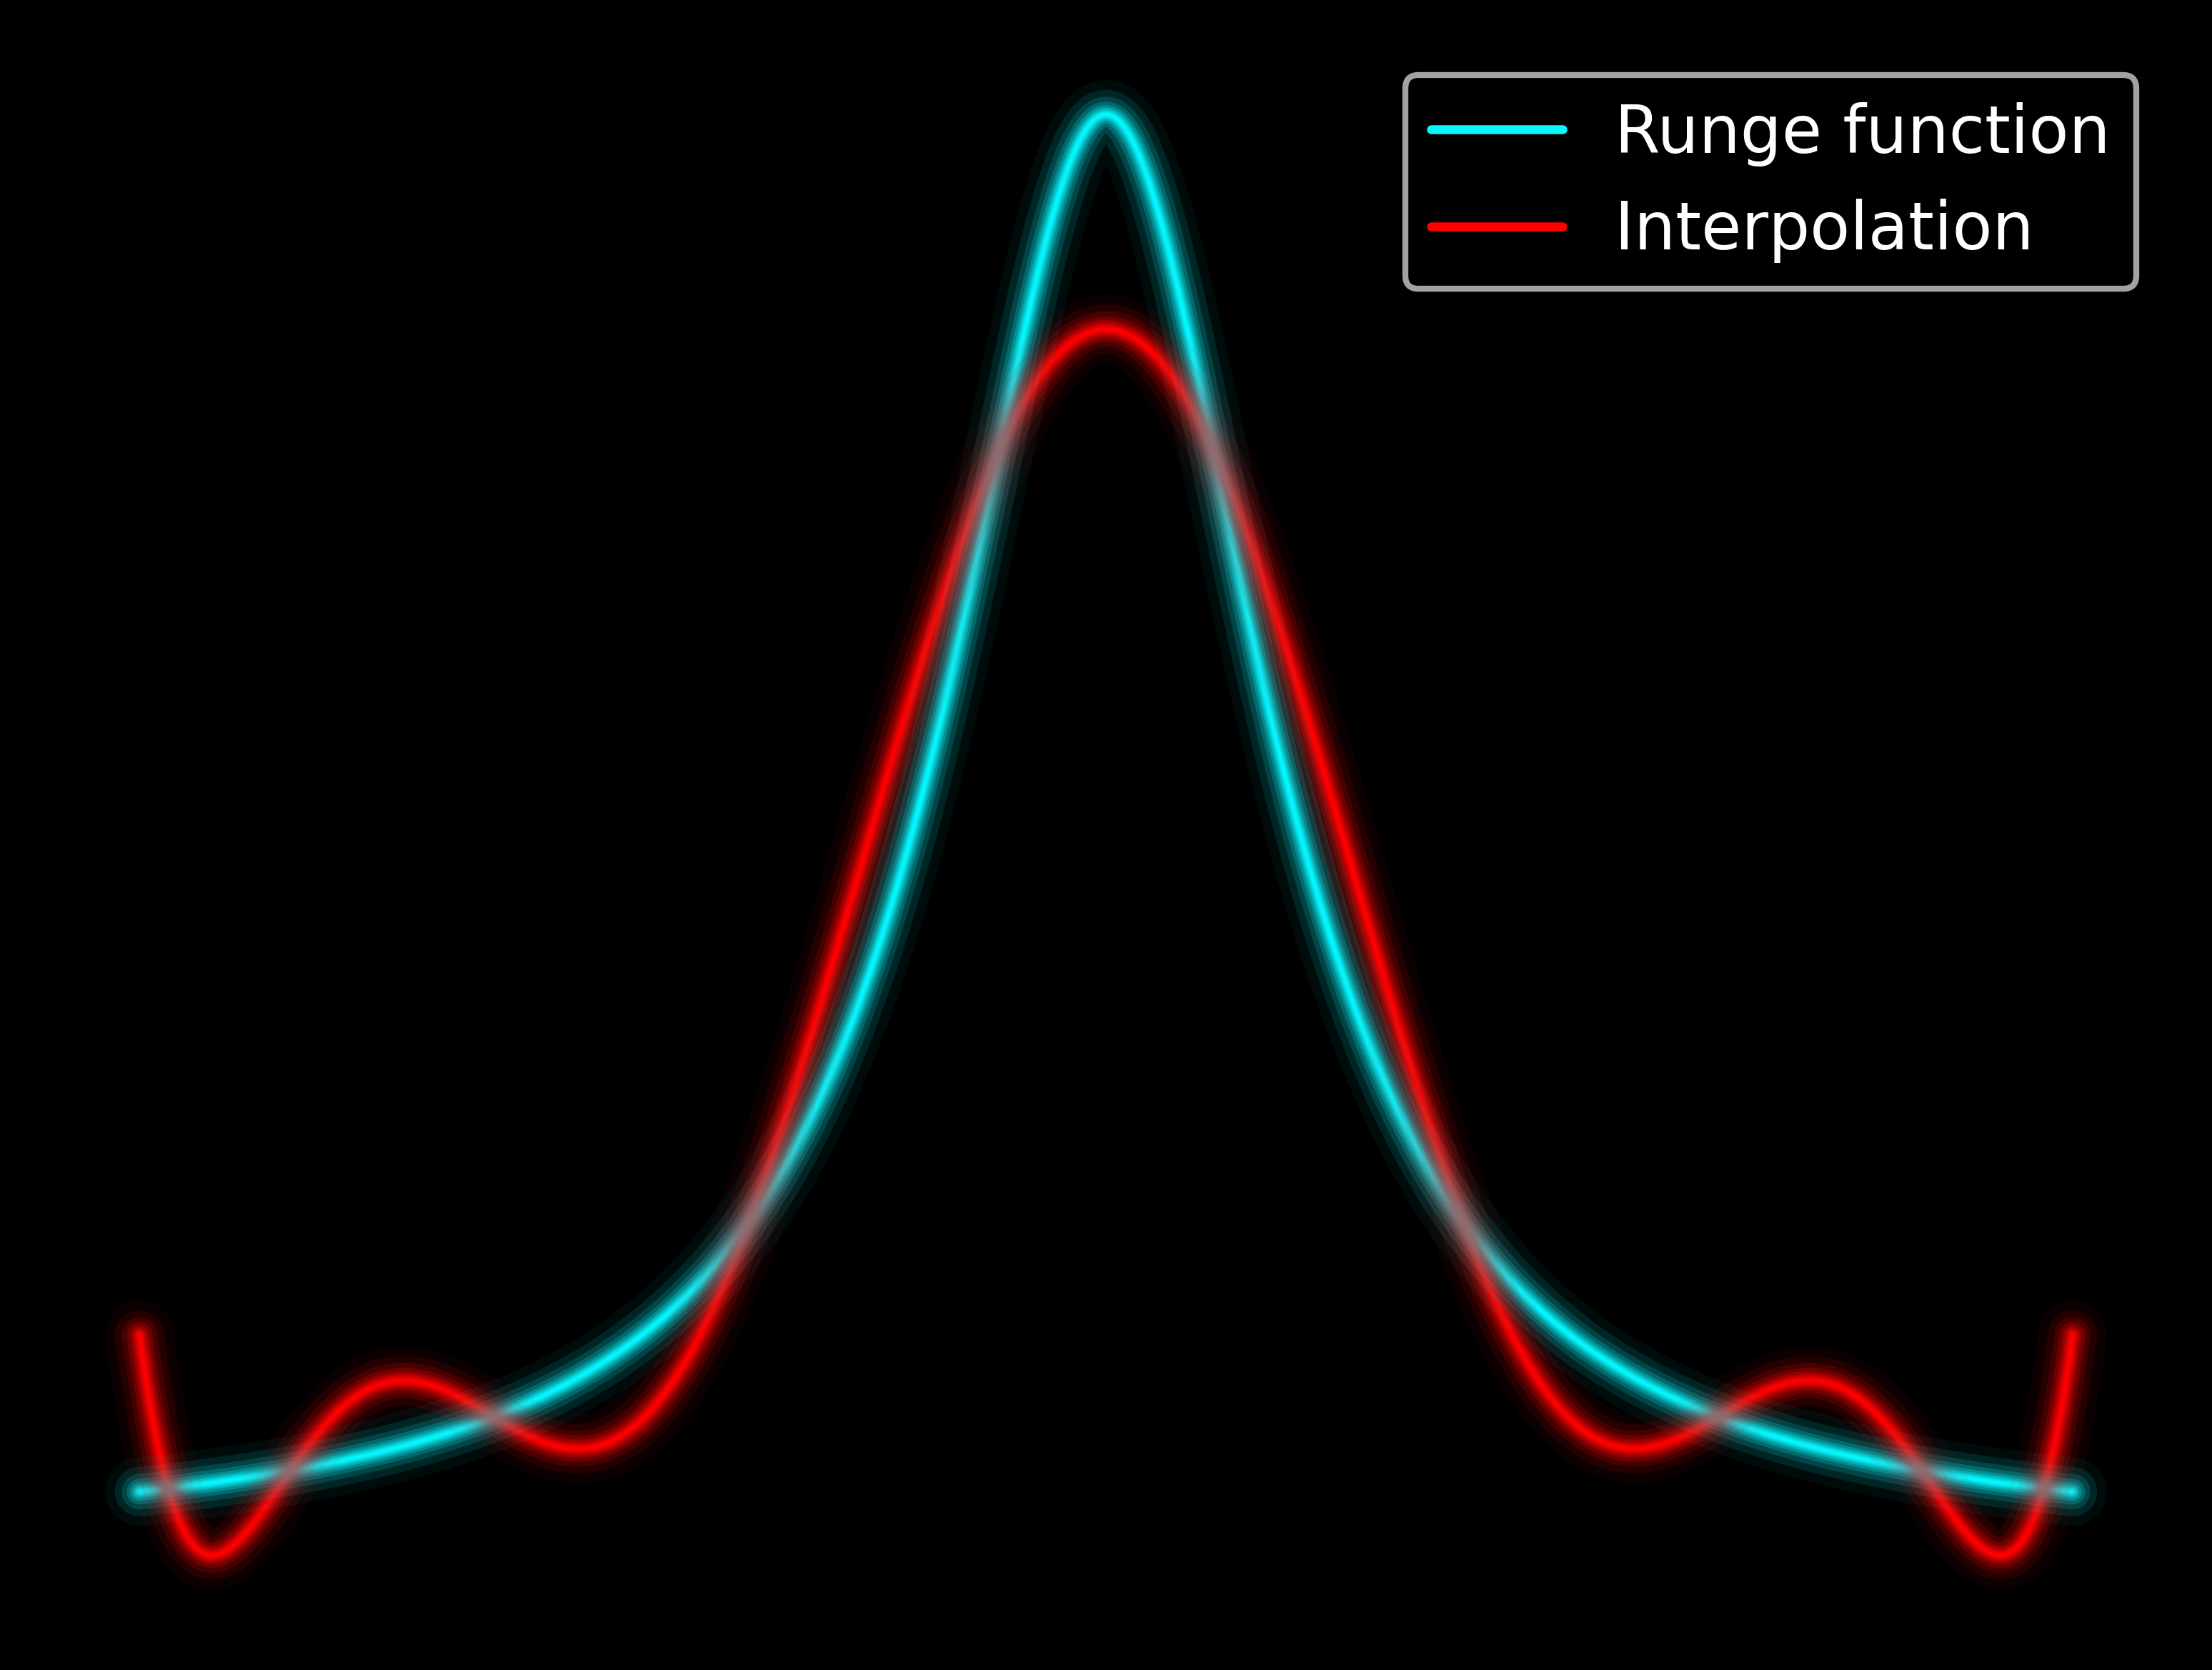

In [26]:

# Convert mpmath matrix to NumPy array for plotting
reconstructed_function_np = np.array(reconstructed_function.tolist()[0])

# Plot the Runge function and its interpolation
fig, ax = plt.subplots(dpi=600)
plt.axis("off") 
plt.style.use('dark_background')
linewidths     = np.logspace(-5, 4, 20, base=2)
transparencies = np.linspace(+1, 0, 20)
for lw, alpha in zip(linewidths, transparencies):
    plt.plot(x_points, y_points, lw=lw, alpha=alpha, c='#08F7FE')
    plt.plot(x_points, reconstructed_function_np, lw=lw, alpha=alpha, c='red')
plt.plot([],[], label = "Runge function", c='#08F7FE')
plt.plot([],[], label = "Interpolation", c='red')
plt.legend()
plt.savefig("figures/runge.png")
plt.show()